In [83]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import  train_test_split,KFold,cross_val_score,cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error,median_absolute_error,r2_score,make_scorer
from sklearn.linear_model import  LinearRegression
from sklearn.tree import  DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier,GradientBoostingRegressor,RandomForestClassifier,RandomForestRegressor
from xgboost import XGBRegressor

In [84]:
house_price_dataset = fetch_california_housing()

In [85]:
df = pd.DataFrame(house_price_dataset.data, columns=house_price_dataset.feature_names)
df['PRICE'] = house_price_dataset.target

In [86]:
df.shape

(20640, 9)

In [87]:
df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,PRICE
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [88]:
df.isnull().sum()

MedInc        0
HouseAge      0
AveRooms      0
AveBedrms     0
Population    0
AveOccup      0
Latitude      0
Longitude     0
PRICE         0
dtype: int64

In [89]:
X = df.drop('PRICE',axis='columns')
Y = df['PRICE']

In [90]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [91]:
X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)

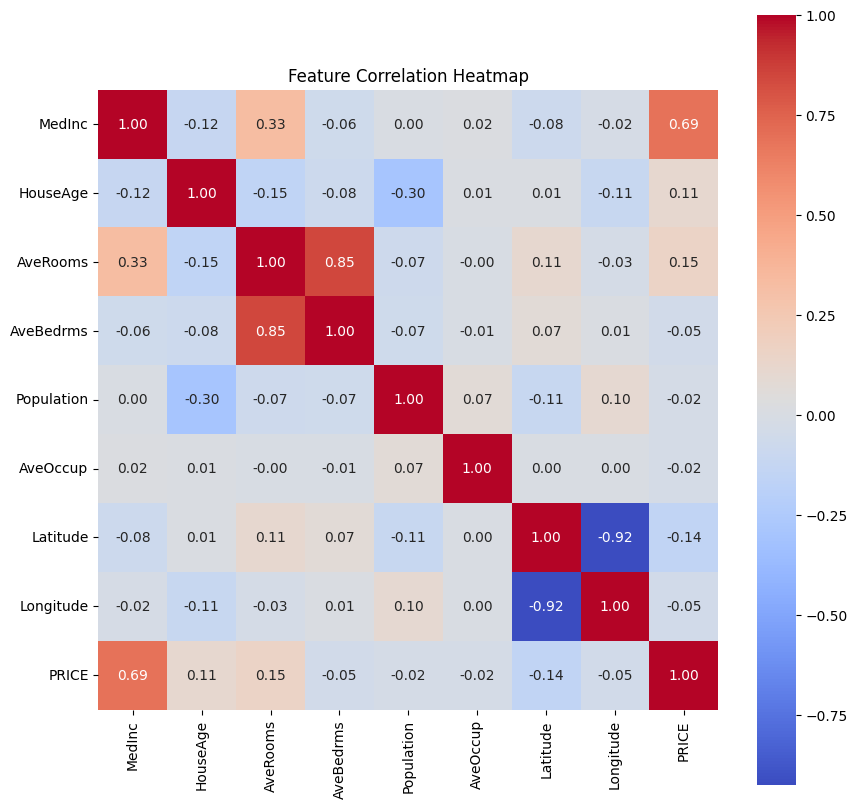

In [92]:
plt.figure(figsize=(10,10))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title('Feature Correlation Heatmap')
plt.show()

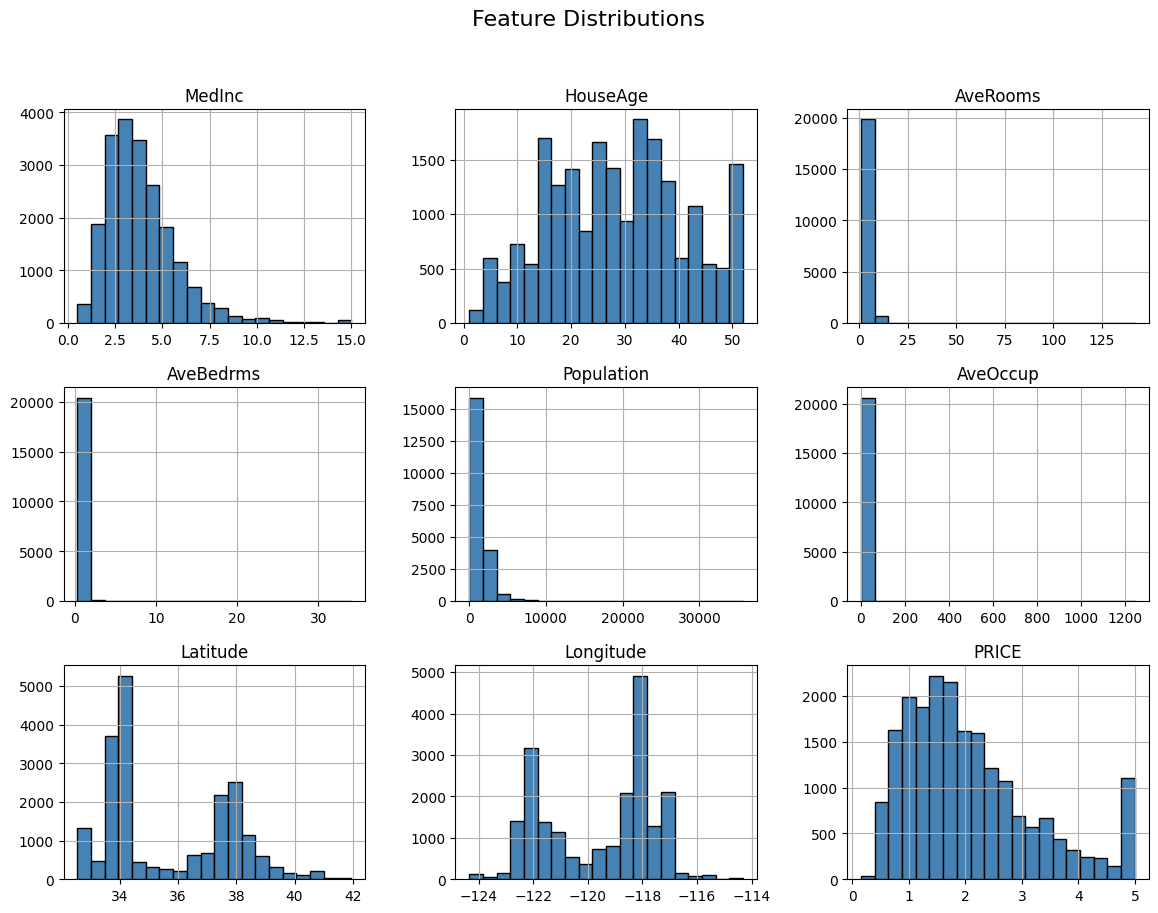

In [93]:
df.hist(bins=20, figsize=(14,10), color='steelblue', edgecolor='black')
plt.suptitle('Feature Distributions', fontsize=16)
plt.show()

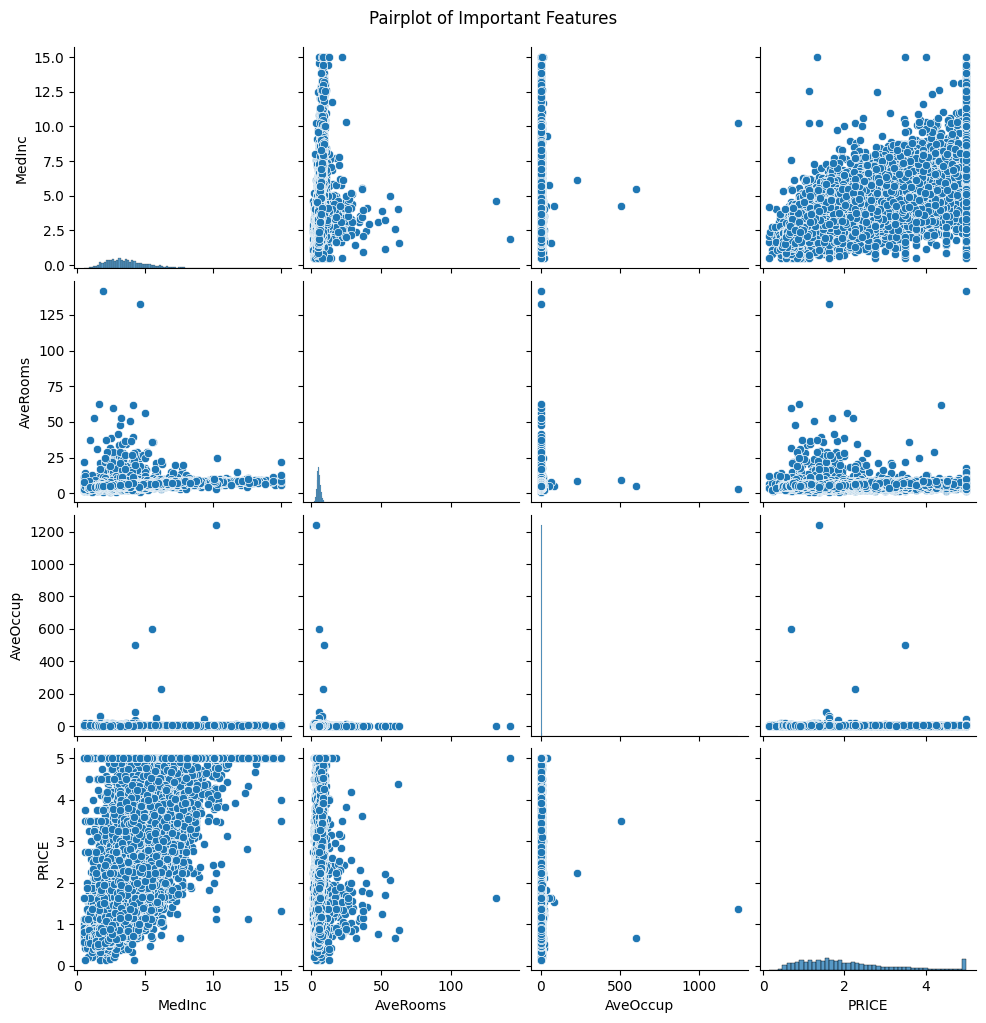

In [94]:
sns.pairplot(df[['MedInc', 'AveRooms', 'AveOccup', 'PRICE']])
plt.suptitle('Pairplot of Important Features', y=1.02)
plt.show()

In [95]:
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(random_state=42, n_estimators=200),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42, n_estimators=200),
    "XGBoost": XGBRegressor(objective='reg:squarederror', random_state=42, n_estimators=200)
}

In [96]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [97]:
def evaluate_model(model, X, Y):
    r2 = cross_val_score(model, X, Y, cv=kf, scoring='r2')
    mae = -cross_val_score(model, X, Y, cv=kf, scoring='neg_mean_absolute_error')
    rmse = np.sqrt(-cross_val_score(model, X, Y, cv=kf, scoring='neg_mean_squared_error'))
    return np.mean(r2), np.mean(mae), np.mean(rmse)


In [98]:
results = {}

for name, model in models.items():
    r2, mae, rmse = evaluate_model(model, X_train, Y_train)
    results[name] = {'R2 (CV avg)': r2, 'MAE (CV avg)': mae, 'RMSE (CV avg)': rmse}

In [99]:
results_df = pd.DataFrame(results).T
results_df

,R2 (CV avg),MAE (CV avg),RMSE (CV avg)
Linear Regression,0.611457,0.529061,0.720510
Decision Tree,0.597245,0.473772,0.733292
Random Forest,0.805692,0.333662,0.509566
Gradient Boosting,0.809380,0.347776,0.504717
XGBoost,0.830451,0.314503,0.476018


C:\Users\HP\AppData\Local\Temp\ipykernel_12396\47545913.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=results_df.index, y=results_df['R2 (CV avg)'], palette='viridis')


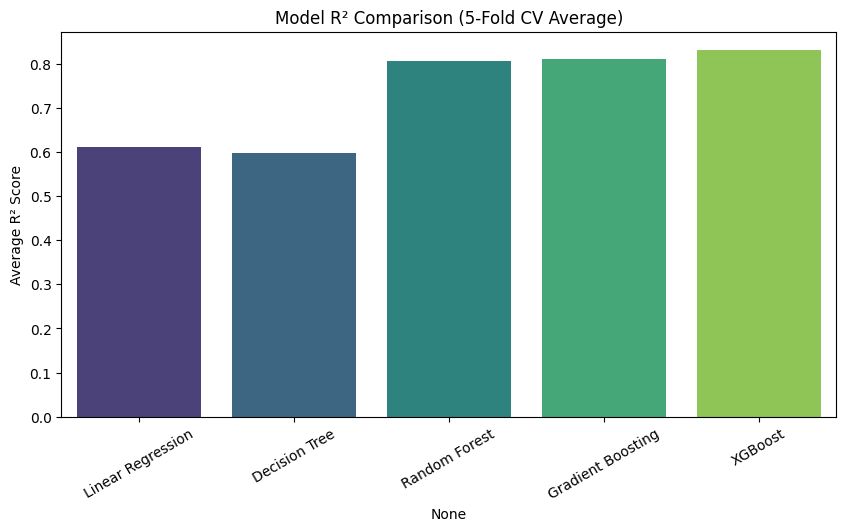

In [100]:
plt.figure(figsize=(10,5))
sns.barplot(x=results_df.index, y=results_df['R2 (CV avg)'], palette='viridis')
plt.title("Model R² Comparison (5-Fold CV Average)")
plt.ylabel("Average R² Score")
plt.xticks(rotation=30)
plt.show()

In [101]:
best_model_name = results_df['R2 (CV avg)'].idxmax()
best_model = models[best_model_name]
print(f"\nBest Model after Cross-Validation: {best_model_name}")



Best Model after Cross-Validation: XGBoost


In [102]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

best_model.fit(X_train, Y_train)

y_pred = best_model.predict(X_test)

r2 = r2_score(Y_test, y_pred)
mae = mean_absolute_error(Y_test, y_pred)
rmse = np.sqrt(mean_squared_error(Y_test, y_pred))

In [103]:
print(f"\nFinal Evaluation on Test Data ({best_model_name}):")
print(f"R² Score: {r2:.3f}")
print(f"Mean Absolute Error: {mae:.3f}")
print(f"Root Mean Squared Error: {rmse:.3f}")


Final Evaluation on Test Data (XGBoost):
R² Score: 0.832
Mean Absolute Error: 0.307
Root Mean Squared Error: 0.469


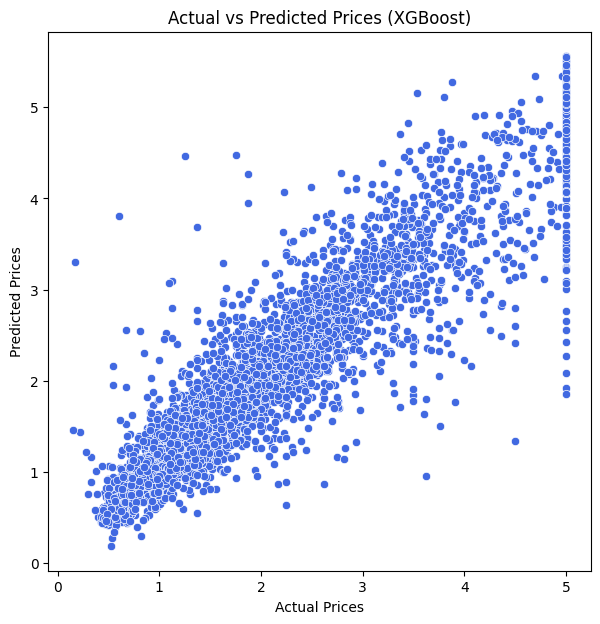

In [104]:
plt.figure(figsize=(7,7))
sns.scatterplot(x=Y_test, y=y_pred, color='royalblue')
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title(f"Actual vs Predicted Prices ({best_model_name})")
plt.show()

In [105]:
bins = np.linspace(Y.min(), Y.max(), 10)
actual_binned = np.digitize(Y_test, bins)
pred_binned = np.digitize(y_pred, bins)

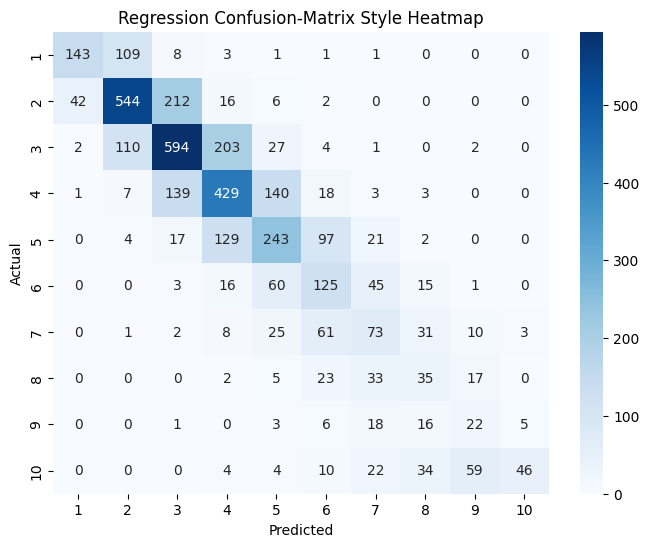

In [ ]:
conf_matrix = pd.crosstab(actual_binned, pred_binned, rownames=['Actual'], colnames=['Predicted'])
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, cmap='Blues', annot=True, fmt='d')
plt.title('Regression  Confusion-Matrix Style Heatmap')
plt.show()